## Evaluate Detectron2 with Custom COCO Datasets

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os 
import gdown
import torch

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Register your own data set in coco format

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances('subt_train', {}, 
                        '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_train.json', 
                       '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_train')
register_coco_instances('subt_val', {}, 
                        '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_val.json', 
                       '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_val')

In [ ]:
subt_metadata = MetadataCatalog.get("subt_val")
dataset_dicts = DatasetCatalog.get("subt_val")
subt_metadata

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("subt_train",)
cfg.DATASETS.TEST = ("subt_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes

Now, let's run inference with the trained model on the validation dataset.  
First, let's create a predictor using the model we trained.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0096989.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("subt_val", )
predictor = DefaultPredictor(cfg)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(False)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.8, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')

We can also evaluate its performance using AP metric implemented in COCO API. This gives an AP of ~70%. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
with torch.no_grad():
    evaluator = COCOEvaluator("subt_val", cfg, False, output_dir="./output/")
    val_loader = build_detection_test_loader(cfg, "subt_val")
    inference_on_dataset(trainer.model, val_loader, evaluator)

## Run segmentation on a video
SubT Urban Alpha Course Configuration 1 Artifact : https://www.youtube.com/watch?v=T5M1zDDZy24  
SubT Urban Alpha Course Configuration 2 Artifact : https://www.youtube.com/watch?v=mhNAX1dpl84  
SubT Urban Beta Course Configuration 1 Artifact : https://www.youtube.com/watch?v=Amb1ghx8IRM  
SubT Urban Beta Course Configuration 2 Artifact : https://www.youtube.com/watch?v=Eejmchll0l8


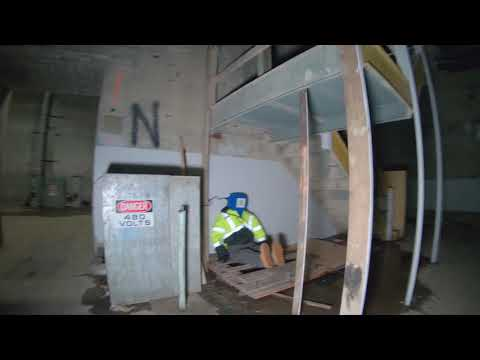

In [1]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("mhNAX1dpl84", width=500)
display(video)

Download video

In [ ]:
!youtube-dl https://www.youtube.com/watch?v=Eejmchll0l8 -f 22 -o video.mp4

Start predict video

In [ ]:
!python /home/arg/detectron2/demo/demo.py \
--config-file /home/arg/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml \
--video-input video.mp4 --confidence-threshold 0.8 --output MaskRCNN-Beta-test.mkv \
--opts MODEL.WEIGHTS /home/arg/detectron2/tools/output/model_0096989.pth MODEL.ROI_HEADS.NUM_CLASSES 5 DATASETS.TEST "('subt_val',)" \